Custom line with additional jitter term
========================================

Optimization terminated successfully.
         Current function value: 384.634484
         Iterations: 2
         Function evaluations: 69
-------------------- Parameter summary ----------------------
     const =    -0.355683, free: T, restricted: F, related: F
     slope =      1.10116, free: T, restricted: F, related: F
    jitter =      2.97802, free: T, restricted: F, related: F
-------------------------------------------------------------


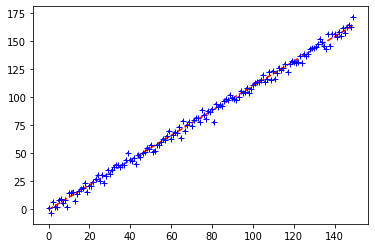

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import funcFit2 as fuf2
import scipy.optimize as sco

np.random.seed(1234)

class LinMod(fuf2.MBO):
    """ Linear model with additional jitter """

    def __init__(self):
        fuf2.MBO.__init__(self, pars=["const", "slope", "jitter"], rootName="LinMod")

    def evaluate(self, x):
        """ Evaluate model """
        return self["const"] + x * self["slope"]

    def logL(self, x, y, yerr, **kwargs):
        """ ln(Likelihood) including jitter as additional term """
        yr = np.sqrt(yerr**2 + self["jitter"]**2)
        m = self.evaluate(x)
        lnl = -len(x)/2.0*np.log(2.*np.pi) - np.sum(np.log(yr)) - 0.5 * np.sum((m-y)**2/(yr**2))
        return lnl

# Instantiate model
lm = LinMod()
# Starting values
lm["slope"] = 1.1
lm["const"] = -0.5
lm["jitter"] = 1

# Use -log(L) as SciPy-like objective function and call it logl
lm.addSPLikeObjf("-logl", "logl")

# Get some 'data' and add Gaussian noise with STD 1+3**2=10
x = np.arange(150.)
y = lm.evaluate(x) + np.random.normal(0,np.sqrt(1+3**2),len(x))
# Nominal error has STD 1
yerr = np.ones_like(x)

lm.thaw(["slope", "const", "jitter"])

fr = sco.fmin_powell(lm.logl, x0=lm.freeParamVals(), args=(x,y,yerr))
lm.setFreeParamVals(fr)

lm.parameterSummary()

plt.errorbar(x, y, yerr=yerr, fmt='b+')
plt.plot(x, lm.evaluate(x), 'r--')
plt.show()